In [ ]:
import numpy as np
# load one of the saved files
loaded_data = np.load('/home/kyuan/RadarPulse/dataset/pilot_1115/train/1110_ultraseat_amit_r1.npz', allow_pickle=True)

# print the keys of the loaded file
print(loaded_data['head_data'].shape, loaded_data['head_label'].shape)
print(loaded_data['head_data'].dtype, loaded_data['head_label'].dtype)
# print the data and label shapes
# print(loaded_data['head'].shape, loaded_data['head_label'].shape)
# print(loaded_data['heart'].shape, loaded_data['heart_label'].shape)
# print(loaded_data['wrist'].shape, loaded_data['wrist_label'].shape)


(38, 5000, 4, 19) (38, 5000, 1)
complex128 int64


In [ ]:
from data.dataset import PulseDataset
trainset = PulseDataset('/home/kyuan/RadarPulse/dataset/pilot_1115/train')
_, _, heart_data, heart_label, _, _ = trainset[0]
print(heart_data.shape, heart_label.shape)
print(heart_data.dtype, heart_label.dtype)

import matplotlib.pyplot as plt
plt.plot(heart_label)

100%|██████████| 6/6 [00:01<00:00,  4.15it/s]

Heart data shape:  torch.Size([225, 5000, 42]) Heart label shape:  torch.Size([225, 5000, 1])


In [ ]:
from src.data.datamodule import PulseDataModule
dm = PulseDataModule('/home/kyuan/RadarPulse/dataset/pilot_1115', batch_size=32, num_workers=4)

In [1]:
from src.config.config_utils import load_config
config = load_config('src/config')

In [2]:
from src.data.datamodule import PulseDataModule
data_module = PulseDataModule(
    data_path=config.data.data_path,
    batch_size=config.training.batch_size,
    num_workers=config.training.num_workers
)
data_module.setup(stage='fit')

Setting up training dataset


100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Heart data shape:  torch.Size([225, 5000, 42]) Heart label shape:  torch.Size([225, 5000, 1])
Setting up validation dataset


100%|██████████| 6/6 [00:00<00:00, 26.17it/s]

Heart data shape:  torch.Size([41, 5000, 42]) Heart label shape:  torch.Size([41, 5000, 1])


In [ ]:
# Initialize model
for batch in data_module.train_dataloader():
    # head_data_shape = batch[0].shape
    heart_data_shape = batch[2].shape
    # wrist_data_shape = batch[4].shape
    break
channels_heart = heart_data_shape[2]

In [4]:
from src.models.lightning_model import LitModel
model = LitModel(config, type='heart', n_channels=channels_heart)

In [5]:
from pytorch_lightning.utilities.model_summary import ModelSummary
summary = ModelSummary(model, max_depth=2)
print(summary)

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | PulseDetectionNet | 2.7 M 
1 | model.encoder_blocks | ModuleList        | 651 K 
2 | model.lstm           | LSTM              | 790 K 
3 | model.decoder_blocks | ModuleList        | 1.2 M 
4 | model.final          | Sequential        | 3.2 K 
5 | criterion            | PulseLoss         | 0     
-----------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.778    Total estimated model params size (MB)


In [6]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    max_epochs=config.training.max_epochs,
    devices='auto',
    # logger=pl.loggers.TensorBoardLogger('logs/')
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
trainer.fit(model, data_module)

Setting up training dataset


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


Heart data shape:  torch.Size([225, 5000, 42]) Heart label shape:  torch.Size([225, 5000, 1])
Setting up validation dataset


100%|██████████| 6/6 [00:00<00:00, 25.12it/s]
/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/kyuan/RadarPulse/lightning_logs/version_4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | PulseDetectionNet | 2.7 M 
1 | criterion | PulseLoss         | 0     
------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.778    Total estimated model params size (MB)


Heart data shape:  torch.Size([41, 5000, 42]) Heart label shape:  torch.Size([41, 5000, 1])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


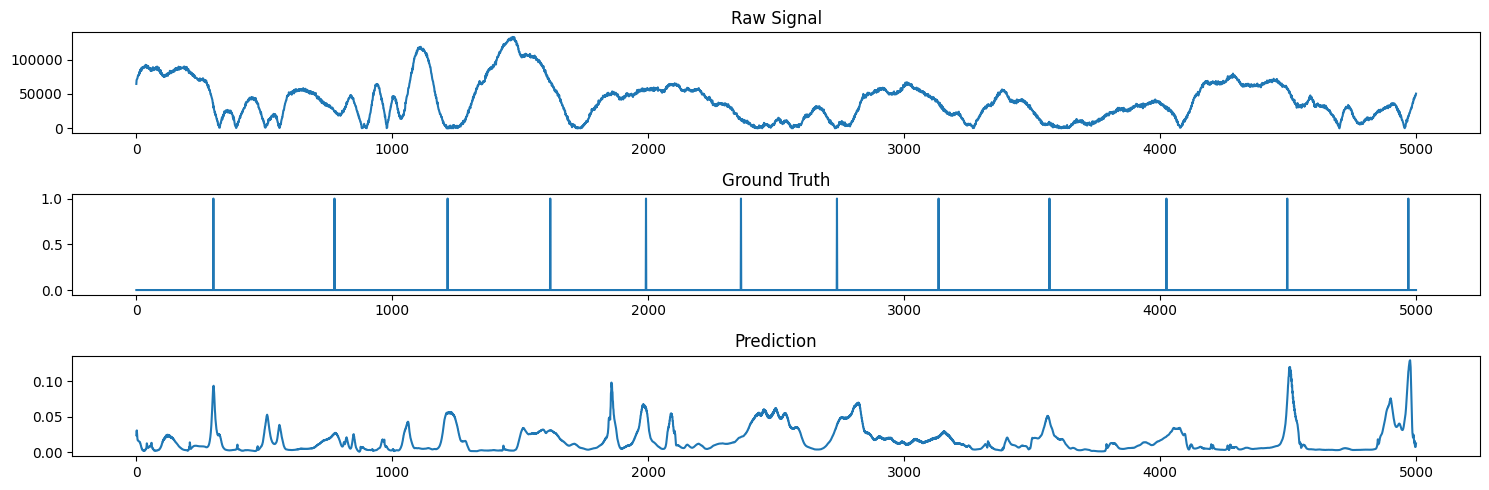

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# Get validation batch and make predictions
for batch in data_module.train_dataloader():
    heart_data = batch[2].to(model.device)  # Move to GPU if available
    heart_label = batch[3].to(model.device)
    break

# with torch.no_grad():
heart_pred = model(heart_data)

# Convert to numpy for plotting
heart_data = heart_data[0].cpu().detach().numpy()  # First sample in batch
heart_label = heart_label[0].cpu().detach().numpy()
heart_pred = heart_pred[0].cpu().detach().numpy()

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(311)
plt.plot(np.abs(heart_data[:, 0]))  # Plot magnitude of first channel
plt.title('Raw Signal')

plt.subplot(312)
plt.plot(heart_label)
plt.title('Ground Truth')

plt.subplot(313)
plt.plot(heart_pred)
plt.title('Prediction')
plt.tight_layout()
plt.show()